<a href="https://colab.research.google.com/github/malinphy/q_17/blob/main/triplet_patent_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import Model, Input, layers
from tensorflow.keras.layers import *
from typing import List

In [3]:
total_content = np.load('drive/MyDrive/transfer/patent/patent_first/total_content.npy')
total_title = np.load('drive/MyDrive/transfer/patent/patent_first/total_title.npy')

In [4]:
print(total_content.shape)
print(total_title.shape)

(488, 1536)
(488, 1536)


In [5]:
content_index_pos = np.arange(0,len(total_content)).reshape(1,total_content.shape[0])
title_index_pos = np.arange(0,len(total_title)).reshape(1,total_content.shape[0])
pos_labels = np.ones(len(title_index_pos[0]), dtype = 'int32')

In [6]:
### there is a problem in the for loop, check content_index rather than content_index[0]
def neg_generator(content, title, neg_number):
    inp_data = []
    for i,j in zip(content[0], title[0]):
        var1 = np.random.randint(0, len(content[0]), neg_number)
        while i in var1:
            var1 = np.random.randint(0, len(content[0]), neg_number)
        # inp_data.append(list(var1))  
        inp_data.append(np.array(var1))
    return inp_data

In [7]:
negs = neg_generator(content_index_pos, title_index_pos, 4)

In [8]:
def data_aligner(title_index, negs):
    v2 = []
    for i in range(title_index.shape[-1]):
        t_index = title_index[0][i]
        v2.append(np.full(len(negs[i]),t_index))
    v2 = np.concatenate(v2)
    negs = np.concatenate(negs)
    return v2, negs        

In [9]:
title_index_neg,negs = data_aligner(title_index_pos, negs)
neg_labels = np.zeros(len(negs), dtype = 'int32')

In [10]:
print(len(title_index_neg))
print(len(negs))

1952
1952


In [11]:
neg_content_vecs = []
for i in range(len(negs)):
    neg_content_vecs.append(total_content[negs[i]])

In [12]:
neg_content_vecs = np.array(neg_content_vecs)

In [13]:
factorized_title_index_pos = sorted(list(title_index_pos[0])*4)
factorized_abst_index_pos = sorted(list(content_index_pos[0])*4)

In [14]:
df = pd.DataFrame({
    'title_index': factorized_title_index_pos,
    'pos_context_index': factorized_abst_index_pos, 
    'neg_context_index' : negs
})

# Triplet Loss Function

In [18]:
def distance_calc(y_true, y_pred):
    anchor, positive, negative = tf.split(y_pred, 3, axis=1)
    ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
    an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
    loss = ap_distance - an_distance
    margin = 0
    loss = tf.maximum(loss + margin, 0.0)
    return loss

In [19]:
anc_inp = Input(1536, name = 'anchor_input')
pos_inp = Input(1536, name = 'positive_input')
neg_inp = Input(1536, name = 'negative_input')
final = tf.keras.layers.Concatenate(axis=-1)([anc_inp, pos_inp, neg_inp])

triplet_model = Model(inputs = [anc_inp, pos_inp, neg_inp], outputs= [final])
triplet_model.compile(
    optimizer = 'Adam',
    loss = distance_calc
)

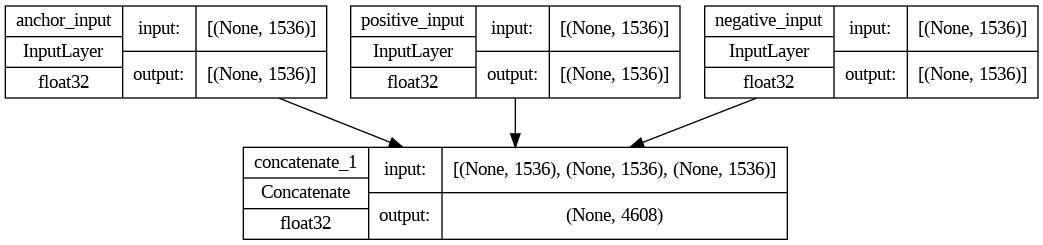

In [35]:
tf.keras.utils.plot_model(
    triplet_model,
    # to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    # show_trainable=False,
)




In [25]:
dummy_labes = np.ones(len(df))

In [27]:
triplet_model.fit(
    [
    total_title[df['title_index'].values],
    total_content[df['pos_context_index'].values],
    total_content[df['neg_context_index'].values],
    ], 
    dummy_labes,
    epochs = 500, 
    verbose = 0
    )